<a href="https://colab.research.google.com/github/solosolve-ai/solosolve-ai-demo/blob/main/Gemini_SFT_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Please ensure you have imported a Gemini API key from AI Studio.
You can do this directly in the Secrets tab on the left.

After doing so, please run the setup cell below.

In [1]:
!pip install -U -q "google"
!pip install -U -q "google.genai"
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.3/196.3 kB 3.2 MB/s eta 0:00:00


In [2]:
import os
from google.colab import userdata
from google.colab import drive
os.environ["GEMINI_API_KEY"] = userdata.get("GOOGLE_API_KEY")

drive.mount("/content/drive")
# Please ensure that uploaded files are available in the AI Studio folder or change the working folder.
os.chdir("/content/drive/MyDrive/Google AI Studio")

Mounted at /content/drive


# Generated Code

In [3]:
# To run this code you need to install the following dependencies:
# pip install google-genai

import base64
import os
from google import genai
from google.genai import types
from tqdm.auto import tqdm # <--- ADD THIS LINE


def generate():
    client = genai.Client(
        api_key=os.environ.get("GEMINI_API_KEY"),
    )

    model = "gemini-2.5-flash-preview-04-17"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text="""INSERT_INPUT_HERE"""),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
        response_mime_type="text/plain",
    )

    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        print(chunk.text, end="")

if __name__ == "__main__":
    generate()


Okay, I see the placeholder `INSERT_INPUT_HERE`.

Please provide the text, code, or instructions you would like me to process by replacing `INSERT_INPUT_HERE` with your input.

I'm ready when you are!

In [4]:
# Snippet 1.1: Installs and Setup (Modified for datasets)
!pip install -U -q "datasets>=2.14.0" "pandas>=1.5.0" "ipywidgets" "html5lib" "sentence-transformers>=2.2.0" "chromadb>=0.4.24" "plotly>=5.0.0" "wordcloud" "scikit-learn"

import os
import json
import time
import pandas as pd
from google.colab import userdata, drive # Assuming this is a Colab environment
import google.generativeai as genai
from datasets import load_dataset, Dataset
import random
from datetime import datetime, timedelta
import html # For unescaping
import re
from tqdm.auto import tqdm
import chromadb
from chromadb.utils import embedding_functions # For ChromaDB
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split # For stratified sampling
import traceback # For error logging

print("Cell 1.1: Imports and Installs completed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.7 MB/s e

In [5]:
# Snippet 1.2: Global Configurations, Constants, and Client Setup

# --- Google Drive and API Key Setup ---
GOOGLE_AI_STUDIO_FOLDER = "/content/drive/MyDrive/Google AI Studio/AmazonFashionSFT"
os.makedirs(GOOGLE_AI_STUDIO_FOLDER, exist_ok=True)
print(f"Project folder set to: {GOOGLE_AI_STUDIO_FOLDER}")

# --- Configure Gemini Client ---
gemini_model_instance = None
MODEL_TO_USE_FOR_SFT_GENERATION = "gemini-2.5-flash-preview-05-20"
try:
    if not getattr(genai, '_is_configured_s1_main_final_v5', False): # Unique flag
        gemini_api_key = os.environ.get("GEMINI_API_KEY")
        if not gemini_api_key:
            raise ValueError("GEMINI_API_KEY not found in environment variables or Colab secrets.")
        genai.configure(api_key=gemini_api_key)
        gemini_model_instance = genai.GenerativeModel(MODEL_TO_USE_FOR_SFT_GENERATION)
        genai._is_configured_s1_main_final_v5 = True
        print(f"Gemini client configured and model '{MODEL_TO_USE_FOR_SFT_GENERATION}' initialized.")
    else:
        if getattr(genai, '_is_configured_s1_main_final_v5', False) and gemini_model_instance is None :
             gemini_model_instance = genai.GenerativeModel(MODEL_TO_USE_FOR_SFT_GENERATION)
        print(f"Gemini client already configured. Model '{MODEL_TO_USE_FOR_SFT_GENERATION}' ensured.")
except Exception as e:
    print(f"Error configuring/initializing Gemini client: {e}. SFT Data Generation might fail.")
    traceback.print_exc()

# --- SFT Dataset Generation Configuration ---
SAMPLES_TO_GENERATE_FROM_CURATED = 100
OUTPUT_SFT_FOLDER = os.path.join(GOOGLE_AI_STUDIO_FOLDER, "sft_output_amazon_fashion_raft_final")
os.makedirs(OUTPUT_SFT_FOLDER, exist_ok=True)
SFT_DATASET_FILENAME = "amazon_fashion_sft_data_raft_final_v5.jsonl" # Versioning
SFT_DATASET_FILE_PATH = os.path.join(OUTPUT_SFT_FOLDER, SFT_DATASET_FILENAME)

# --- Source Data Paths ---
CURATED_COMPLAINTS_SOURCE_FILE = os.path.join(GOOGLE_AI_STUDIO_FOLDER, "curated_fashion_complaints.parquet")
RAW_DATASET_NAME_MCANLEY = "McAuley-Lab/Amazon-Reviews-2023"
RAW_REVIEW_CONFIG_MCANLEY = "raw_review_Amazon_Fashion"
RAW_META_CONFIG_MCANLEY = "raw_meta_Amazon_Fashion"

# --- Knowledge Base Paths (ChromaDB) ---
POLICY_DB_PATH = os.path.join(GOOGLE_AI_STUDIO_FOLDER, "policy_chroma_db_final_v5")
UDP_DB_PATH = os.path.join(GOOGLE_AI_STUDIO_FOLDER, "udp_chroma_db_final_v5")
EMBEDDING_MODEL_NAME = 'all-MiniLM-L6-v2'
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name=EMBEDDING_MODEL_NAME)

# --- Core Business Logic Definitions ---
AMAZON_POLICY_DICT = {
    "Return Window": "Most items can be returned within 30 days of delivery. Some exceptions apply, especially for fashion items which must be unworn with tags.",
    "Non-Returnable Items": "Digital music, groceries, customized products, hazardous materials are non-returnable. Final sale items may also be non-returnable.",
    "Damaged or Defective": "If an item arrives damaged, defective, or is not the item you ordered, contact Customer Service immediately. Photographic evidence is often required for claims. Resolution typically involves a refund or replacement.",
    "Fashion Item Returns": "Fashion items (clothing, shoes, jewelry, watches) must be returned in new and unworn condition, with all original packaging, tags, and certificates of authenticity. Items showing signs of wear, alteration, or customer damage may be rejected or incur a restocking fee up to 50%.",
    "Refund Process": "Once a return is received and inspected, refunds are processed within 5-7 business days to the original payment method. Shipping fees are generally non-refundable unless the return is due to Amazon error."
}
COMPLAINT_CATEGORIES = sorted(["Sizing Issue", "Damaged Item", "Not as Described", "Shipping Problem", "Policy Inquiry", "Late Delivery", "Wrong Item Received", "Quality Issue", "Return Process Issue", "Customer Service Issue", "Pricing Error", "Other"])
DECISION_TYPES = sorted(["Full_Refund_No_Return", "Full_Refund_With_Return", "Partial_Refund_No_Return", "Partial_Refund_With_Return", "Exchange_Offered", "Deny_Request_Policy_Violation", "Further_Information_Required", "Escalate_To_Human_Agent", "Provide_Policy_Information", "Apology_Only", "Other_Resolution"])
EMOTIONAL_TONES_FOR_FORMAL_ANSWER = sorted(["Empathetic_Standard", "Neutral_Direct", "Understanding_Apologetic", "Firm_Polite", "Helpful_Informative", "Conciliatory_SolutionOriented", "Other"])
SENTIMENT_CATEGORIES = sorted(["positive", "neutral", "negative", "mixed", "very_negative", "N/A"])
AGGRESSION_LEVELS = sorted(["none", "low", "medium", "high", "N/A"])

# --- Constants for Data Processing & SFT Generation ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
BAD_RATING_THRESHOLD = 2.1
MIN_REVIEW_TEXT_LENGTH = 30
UDP_HISTORY_DAYS = 180
MAX_JSON_OUTPUT_TOKENS_TARGET = 700

AMAZON_RETURN_STATS = { # ... (keep as before) ...
}
print(f"SFT data will be saved to: {SFT_DATASET_FILE_PATH}")
print(f"Source complaint file expected at: {CURATED_COMPLAINTS_SOURCE_FILE}")

# --- Pre-format Enum Strings for Prompt Templates ---
complaint_categories_enums_str = "' | '".join(COMPLAINT_CATEGORIES)
decision_types_enums_str = "' | '".join(DECISION_TYPES)
emotional_tones_enums_str = "' | '".join(EMOTIONAL_TONES_FOR_FORMAL_ANSWER)
sentiment_categories_enums_str = "' | '".join(SENTIMENT_CATEGORIES)
aggression_levels_enums_str = "' | '".join(AGGRESSION_LEVELS)

# --- Teacher Prompt Template (for Gemini) ---
TEACHER_PROMPT_TEMPLATE = f"""
You are an AI assistant, an Amazon Resolution Expert. Your task is to analyze the provided customer complaint, product information, user profile, and relevant policy snippets to generate a comprehensive, gold-standard JSON output. This JSON will serve as training data for a smaller model.
Carefully consider all provided information for THIS SPECIFIC COMPLAINT to ensure your JSON output is accurate and diverse, not a generic template.

**CUSTOMER COMPLAINT (REVIEW):**
Title: "{{complaint_title_text}}"
Rating Given: {{complaint_rating_given}}
Review Text: "{{complaint_body_text}}"
Verified Purchase: {{complaint_verified_purchase}}
Complaint Timestamp: {{complaint_timestamp_iso}}
Inferred Complaint Driver: {{complaint_inferred_driver_for_gemini}}

**PRODUCT CONTEXT:**
Product Title: {{product_title}}
Product ASIN: {{product_asin}}
Product Price: ${{product_price}}
Main Category: {{product_main_category}}
Sub Category: {{product_sub_category}}
Store: {{product_store}}
Key Features: {{product_features}}
Average Product Rating: {{product_avg_rating}}/5 ({{product_rating_number}} reviews)

**USER DYNAMIC PROFILE SUMMARY (Historical Context):**
{{user_dynamic_profile_summary}}

**RELEVANT AMAZON POLICY SNIPPETS (Golden Documents - Prioritize these for your reasoning):**
{{retrieved_relevant_policies_text}}

**OTHER POLICY SNIPPETS (Distractor Documents - Consider if relevant, but focus on golden documents):**
{{retrieved_distractor_policies_text}}

**SIMULATED PURCHASE DATE (for return window assessment):** {{purchase_date_str}}
(Assess if the complaint falls within a typical 30-day return window from this purchase date, considering the 'Return Window' policy.)

**IMAGE ANALYSIS (Conceptual - based on URLs if provided, otherwise state 'No relevant images'):**
Image URLs: {{image_urls_str}}
If Image URLs is 'No product images available', '[]', or similar indicating no images, 'image_analysis_summary' MUST state 'No relevant images provided/analyzed'. Otherwise, briefly describe what the images show relevant to the complaint.

**ADDITIONAL GUIDANCE BASED ON INFERRED COMPLAINT DRIVER ({{complaint_inferred_driver_for_gemini}}):**
{{additional_guidance_for_gemini}}

**YOUR TASK: Generate a SINGLE, VALID JSON object.**
- The 'complaint_category' MUST accurately reflect the nature of THIS SPECIFIC complaint_body_text and inferred_complaint_driver. Do NOT default to a single category.
- The 'decision_recommendation' MUST be logically derived from THIS complaint, the cited policies, and the UDP.
- The 'reasoning_for_decision' MUST be concise (target 3-4 sentences, <100 tokens) and explicitly cite policy titles from 'Relevant Policy Snippets' that justify YOUR decision for THIS case.
- The 'formal_answer_to_customer' should reflect the specific decision, reasoning, and chosen tone for THIS case.
- The overall JSON output should be compact (target <{{max_json_output_tokens}} tokens).
- Infer 'detected_customer_sentiment' and 'detected_aggressiveness_level' based on the review text and user profile.

**REQUIRED JSON OUTPUT SCHEMA (Concise Instructions):**
{{{{
  "is_actionable_complaint": boolean,
  "complaint_category": "{complaint_categories_enums_str}",
  "complaint_summary": "string (1-2 sentences, specific to this complaint, integrate image findings)",
  "key_entities_from_complaint": ["list of 3-5 strings from THIS complaint_body_text"],
  "image_analysis_summary": "string ('No relevant images provided/analyzed' or brief description specific to images if provided)",
  "information_completeness_assessment": {{{{ "is_complete": boolean, "missing_information_prompt": "string or 'NA'" }}}},
  "decision_recommendation": "{decision_types_enums_str}",
  "suggested_refund_percentage": integer (0-100),
  "return_instructions_if_applicable": "string or 'NA'",
  "reasoning_for_decision": "string (CONCISE 3-4 sentences, <100 tokens, CITE relevant policy titles used for THIS decision)",
  "detected_customer_sentiment": "{sentiment_categories_enums_str}",
  "detected_aggressiveness_level": "{aggression_levels_enums_str}",
  "formal_answer_to_customer": "string (Starts with '[TONE: <{emotional_tones_enums_str}>] ...', tailored to THIS case)"
}}}}

Response (JSON only):
"""
print("TEACHER_PROMPT_TEMPLATE prepared with pre-formatted enums and enhanced guidance.")

# --- Student Prompt Template Base (for Gemma 3 Fine-tuning) ---
STUDENT_PROMPT_BASE = """
Customer Complaint:
Title: {complaint_title_text}
Review: {complaint_body_text}
Rating: {complaint_rating_given}
Verified Purchase: {complaint_verified_purchase}
Complaint Date: {complaint_timestamp_iso}
Inferred Complaint Driver: {complaint_inferred_driver_for_gemma}

User Profile Summary:
{user_dynamic_profile_summary}

Product Information:
Name: {product_title}
ASIN: {product_asin}
Price: ${product_price}
Category: {product_main_category} / {product_sub_category}
Store: {product_store}
Image URLs (if any): {image_urls_str}

Simulated Purchase Date: {purchase_date_str}

Applicable Policies (Primary Context):
{retrieved_relevant_policies_text}

Other Policies (Secondary Context):
{retrieved_distractor_policies_text}

Based on all the above, generate the structured JSON analysis:
"""
print("STUDENT_PROMPT_BASE prepared.")

# --- Gemini Model Invocation Function ---
def generate_sft_entry_with_gemini(prompt_text_for_gen, attempt=1, max_attempts=3):
    # (Code for this function remains the same as the previous corrected version)
    global gemini_model_instance
    if not gemini_model_instance:
        tqdm.write("Gemini model instance not available for generation.")
        return None
    try:
        gen_config_class = getattr(genai, 'GenerationConfig', getattr(genai.types, 'GenerationConfig', None))
        if gen_config_class is None: raise AttributeError("GenerationConfig class not found in genai or genai.types")

        generation_config_obj = gen_config_class(
            temperature=0.25, # Low temperature for factual JSON
            response_mime_type="application/json" # Request JSON directly
        )
        response = gemini_model_instance.generate_content(
            contents=prompt_text_for_gen,
            generation_config=generation_config_obj,
            request_options={'timeout': 180} # 3 minute timeout
        )
        if response.candidates and response.candidates[0].content.parts:
            raw_text = response.candidates[0].content.parts[0].text
            clean_text = raw_text.strip()
            if clean_text.startswith("```json"): clean_text = clean_text[7:]
            if clean_text.endswith("```"): clean_text = clean_text[:-3]
            if clean_text.startswith('"') and clean_text.endswith('"'): # Handle double-escaped JSON string
                try:
                    potential_json_str = json.loads(clean_text)
                    if isinstance(potential_json_str, str): clean_text = potential_json_str
                except json.JSONDecodeError: pass # Keep clean_text as is if inner part is not valid JSON
            return clean_text.strip()
        else:
            feedback_msg = f"No content parts. Prompt Feedback: {response.prompt_feedback if response and hasattr(response, 'prompt_feedback') else 'N/A'}"
            tqdm.write(f"Warning (Attempt {attempt}): {feedback_msg}")
            # You could inspect response.candidates here if it exists but is empty or parts are missing
            # For example: if response.candidates: tqdm.write(f"Candidate details: {response.candidates[0]}")
            return None
    except Exception as exc:
        tqdm.write(f"Error during Gemini generate_content (Attempt {attempt}): {type(exc).__name__} - {exc}")
        if attempt < max_attempts:
            time.sleep(random.uniform(3, 7) * attempt) # Exponential backoff with jitter
            return generate_sft_entry_with_gemini(prompt_text_for_gen, attempt + 1, max_attempts)
        return None
print("generate_sft_entry_with_gemini function defined with retries and timeout.")

print("Cell 1.2: Global configurations and constants defined.")

Project folder set to: /content/drive/MyDrive/Google AI Studio/AmazonFashionSFT
Gemini client configured and model 'gemini-2.5-flash-preview-05-20' initialized.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SFT data will be saved to: /content/drive/MyDrive/Google AI Studio/AmazonFashionSFT/sft_output_amazon_fashion_raft_final/amazon_fashion_sft_data_raft_final_v5.jsonl
Source complaint file expected at: /content/drive/MyDrive/Google AI Studio/AmazonFashionSFT/curated_fashion_complaints.parquet
TEACHER_PROMPT_TEMPLATE prepared with pre-formatted enums and enhanced guidance.
STUDENT_PROMPT_BASE prepared.
generate_sft_entry_with_gemini function defined with retries and timeout.
Cell 1.2: Global configurations and constants defined.


In [6]:
# Snippet 2.1: PolicyDB Setup (ChromaDB)

# --- Policy Chunking Function ---
def chunk_policies(policy_dict_input):
    chunks = []
    for title, text in policy_dict_input.items():
        chunk_id = f"policy_{title.lower().replace(' ', '_').replace('/', '_')}_main_chunk_001"
        keywords_list = [kw.lower() for kw in re.split(r'\W+', title) if kw] + \
                        [kw.lower() for kw in re.split(r'\W+', text)[:20] if kw]
        keywords_str = ", ".join(list(set(keywords_list)))

        # CORRECTED: The 'text' field for ChromaDB should be the content to be embedded and retrieved.
        # It should already be formatted as "Policy Title: {title}\nPolicy Text: {text}" if that's what you want retrieved.
        # The original AMAZON_POLICY_DICT values are just the text. So we construct the full string here.
        full_policy_text_for_chunk = f"Policy Title: {title}\nPolicy Text: {text}"

        chunks.append({
            "id": chunk_id,
            "text": full_policy_text_for_chunk, # This is what gets embedded and retrieved
            "metadata": {
                "policy_title": title, # Store title separately in metadata for easy access
                "source_document_name": "Amazon Fashion Returns & Refunds Policy Snippets V3",
                "keywords_str": keywords_str,
                "chunk_char_length": len(full_policy_text_for_chunk), # Length of the full text
                "policy_category": "General Fashion Policy"
            }
        })
    return chunks

policy_chunks_list = chunk_policies(AMAZON_POLICY_DICT)
print(f"Created {len(policy_chunks_list)} policy chunks.")

# --- Initialize/Load PolicyDB (ChromaDB) ---
policy_collection = None
try:
    policy_db_client = chromadb.PersistentClient(path=POLICY_DB_PATH)
    policy_collection_name = "amazon_policies_v3" # Incremented version
    policy_collection = policy_db_client.get_or_create_collection(
        name=policy_collection_name,
        embedding_function=sentence_transformer_ef,
        metadata={"hnsw:space": "cosine"}
    )

    current_chunk_ids = [chunk['id'] for chunk in policy_chunks_list]
    if current_chunk_ids:
        existing_docs_in_db = policy_collection.get(ids=current_chunk_ids)
        existing_ids_in_db = set(existing_docs_in_db['ids'])
        new_chunks_to_add = [chunk for chunk in policy_chunks_list if chunk['id'] not in existing_ids_in_db]

        if new_chunks_to_add:
            print(f"Adding {len(new_chunks_to_add)} new documents to PolicyDB collection '{policy_collection.name}'...")
            policy_collection.add(
                ids=[chunk['id'] for chunk in new_chunks_to_add],
                documents=[chunk['text'] for chunk in new_chunks_to_add], # Add the 'text' field
                metadatas=[chunk['metadata'] for chunk in new_chunks_to_add]
            )
            print(f"PolicyDB now contains {policy_collection.count()} documents.")
        else:
            print(f"PolicyDB collection '{policy_collection.name}' is up-to-date with {policy_collection.count()} documents.")
    else:
        print("No policy chunks defined. PolicyDB not populated.")

except Exception as e:
    print(f"Critical Error initializing PolicyDB with ChromaDB: {e}")
    traceback.print_exc()
    policy_collection = None

# --- Policy Retrieval Function (CORRECTED for title duplication) ---
def get_policy_snippets_from_db(complaint_text, pol_coll, num_golden=2, num_distractors=2):
    if not pol_coll:
        return "PolicyDB not available.", "PolicyDB not available for distractors."

    retrieved_golden_texts = [] # Will store the direct 'text' field from ChromaDB
    distractor_texts = []       # Will store the direct 'text' field from ChromaDB
    retrieved_golden_ids = []

    try:
        query_results = pol_coll.query(
            query_texts=[complaint_text],
            n_results=num_golden + num_distractors + 3,
            include=['documents', 'metadatas'] # IDs are part of the main result structure
        )

        all_retrieved_docs_info = [] # Store dicts of {'id': id, 'text': text_from_doc, 'title': title_from_meta}
        if query_results and query_results['ids'] and query_results['ids'][0]:
            for i in range(len(query_results['ids'][0])):
                all_retrieved_docs_info.append({
                    'id': query_results['ids'][0][i],
                    'text': query_results['documents'][0][i], # This is "Policy Title: X\nPolicy Text: Y"
                    'title': query_results['metadatas'][0][i].get('policy_title', 'Unknown Policy')
                })

        if not all_retrieved_docs_info:
            tqdm.write(f"Warning: No documents retrieved from PolicyDB for query: {complaint_text[:100]}")
            return "No relevant policies found.", "No distractor policies selected."

        golden_docs_selected_info = all_retrieved_docs_info[:num_golden]
        retrieved_golden_texts = [g['text'] for g in golden_docs_selected_info] # Use the full text from DB
        retrieved_golden_ids = [g['id'] for g in golden_docs_selected_info]

        potential_distractors_info = [doc for doc in all_retrieved_docs_info if doc['id'] not in retrieved_golden_ids]
        selected_distractors_info = potential_distractors_info[:num_distractors] # Take from query results first

        num_needed_random_distractors = num_distractors - len(selected_distractors_info)
        if num_needed_random_distractors > 0 and policy_chunks_list:
            all_db_chunk_ids = [chunk['id'] for chunk in policy_chunks_list]
            current_selected_ids = retrieved_golden_ids + [d['id'] for d in selected_distractors_info]
            possible_random_distractor_ids = [id_ for id_ in all_db_chunk_ids if id_ not in current_selected_ids]

            if possible_random_distractor_ids:
                actual_random_to_fetch = min(num_needed_random_distractors, len(possible_random_distractor_ids))
                randomly_selected_ids = random.sample(possible_random_distractor_ids, actual_random_to_fetch)

                if randomly_selected_ids:
                    random_distractor_results = pol_coll.get(ids=randomly_selected_ids, include=['documents', 'metadatas']) # Fetch full info
                    if random_distractor_results and random_distractor_results['ids']:
                        for i in range(len(random_distractor_results['ids'])):
                            selected_distractors_info.append({
                                'id': random_distractor_results['ids'][i],
                                'text': random_distractor_results['documents'][i], # This is "Policy Title: X\nPolicy Text: Y"
                                'title': random_distractor_results['metadatas'][i].get('policy_title', 'Unknown Policy')
                            })

        distractor_texts = [d['text'] for d in selected_distractors_info[:num_distractors]] # Use the full text from DB

    except Exception as e:
        tqdm.write(f"Error during policy retrieval or processing: {e}")
        traceback.print_exc()
        return "Error retrieving relevant policies.", "Error retrieving distractor policies."

    golden_docs_output_str = "\n\n".join(retrieved_golden_texts) if retrieved_golden_texts else "No specific relevant policies found for this query."
    distractor_docs_output_str = "\n\n".join(distractor_texts) if distractor_texts else "No distractor policies were selected."

    return golden_docs_output_str, distractor_docs_output_str

print("Cell 2.1: PolicyDB setup and retrieval functions defined and executed.")

Created 5 policy chunks.
PolicyDB collection 'amazon_policies_v3' is up-to-date with 5 documents.
Cell 2.1: PolicyDB setup and retrieval functions defined and executed.


In [7]:
# Snippet 2.2: User Dynamic Profile (UDP) Setup (ChromaDB) & Utilities
# (This cell's code for calculate_udp_features and get_udp_summary_and_features_from_db
#  remains the same as the previous robust version you provided.
#  Ensure udp_collection is initialized correctly here too.)

udp_collection = None # Initialize
try:
    udp_db_client = chromadb.PersistentClient(path=UDP_DB_PATH)
    udp_collection_name = "user_profiles_v2" # Versioned
    udp_collection = udp_db_client.get_or_create_collection(
        name=udp_collection_name,
        embedding_function=sentence_transformer_ef,
        metadata={"hnsw:space": "cosine"}
    )
    print(f"UDP_DB collection '{udp_collection.name}' loaded/created with {udp_collection.count()} profiles.")
except Exception as e:
    print(f"Critical Error initializing UDP_DB with ChromaDB: {e}")
    traceback.print_exc()
    udp_collection = None

def calculate_udp_features(user_id, current_complaint_timestamp_dt, user_history_df):
    # (Content of this function is identical to the previous response's corrected version)
    features = {
        "user_id": str(user_id) if user_id else "unknown_user",
        "profile_last_updated_ts": int(time.time()),
        "total_complaints_count": 0,
        "complaints_count_last_30d": 0,
        "complaints_count_last_90d": 0,
        "complaints_count_last_180d": 0,
        "avg_days_between_complaints": None,
        "date_of_first_complaint_ts": None,
        "date_of_last_complaint_ts": None,
        "avg_rating_given_in_complaints": None,
        "complaint_category_dist_json": "{}",
        "decision_recommendation_dist_json": "{}",
        "avg_suggested_refund_hist": None,
        "count_verified_purchase_complaints": 0,
        "flag_is_chronic": False,
        "flag_has_repeated_category_issues": False,
        "flag_is_meek_tendency": False,
        "flag_is_aggressive_tendency": False,
        "repeated_category_alert_fashion": "None",
        "llm_summary_last_3_interactions": "No recent interactions summarized."
    }
    if user_history_df.empty: return features
    features['total_complaints_count'] = len(user_history_df)
    if not user_history_df['timestamp_review_dt'].isnull().all():
        features['date_of_first_complaint_ts'] = int(user_history_df['timestamp_review_dt'].min().timestamp())
        features['date_of_last_complaint_ts'] = int(user_history_df['timestamp_review_dt'].max().timestamp())
    if len(user_history_df) > 1:
        user_history_df_sorted = user_history_df.sort_values(by='timestamp_review_dt')
        avg_diff = user_history_df_sorted['timestamp_review_dt'].diff().mean()
        if pd.notna(avg_diff): features['avg_days_between_complaints'] = round(avg_diff.total_seconds() / (24 * 3600), 2)
    for days in [30, 90, 180]:
        if pd.notna(current_complaint_timestamp_dt):
            history_recent = user_history_df[(current_complaint_timestamp_dt - user_history_df['timestamp_review_dt']).dt.days <= days]
            features[f'complaints_count_last_{days}d'] = len(history_recent)
        else: features[f'complaints_count_last_{days}d'] = 0
    if 'rating_review' in user_history_df.columns and not user_history_df['rating_review'].isnull().all():
        features['avg_rating_given_in_complaints'] = round(user_history_df['rating_review'].mean(), 2)
    category_col_for_udp = 'inferred_complaint_driver' if 'inferred_complaint_driver' in user_history_df.columns else 'main_category_meta'
    if category_col_for_udp in user_history_df.columns and not user_history_df[category_col_for_udp].isnull().all():
        cat_counts = user_history_df[category_col_for_udp].value_counts().to_dict()
        features['complaint_category_dist_json'] = json.dumps({k:int(v) for k,v in cat_counts.items()})
        if cat_counts:
            most_common_cat = max(cat_counts, key=cat_counts.get)
            if cat_counts[most_common_cat] > features['total_complaints_count'] * 0.4 and features['total_complaints_count'] > 2:
                features['flag_has_repeated_category_issues'] = True
                features['repeated_category_alert_fashion'] = str(most_common_cat)
    if 'verified_purchase_review' in user_history_df.columns: features['count_verified_purchase_complaints'] = int(user_history_df['verified_purchase_review'].sum())
    features['flag_is_chronic'] = bool(features['complaints_count_last_180d'] >= 3)
    past_texts_concat = " ".join(user_history_df['text_review'].fillna('').astype(str).tolist()).lower()
    meek_kws = ['disappointed', 'a bit', 'sadly', 'unfortunately', 'perhaps', 'maybe', 'i guess', 'i wish', 'if only']
    aggressive_kws = ['demand', 'worst', 'never again', 'horrible', 'scam', 'useless', 'garbage', 'ridiculous', 'fix this now', ' unacceptable', 'warning']
    features['flag_is_meek_tendency'] = bool(any(kw in past_texts_concat for kw in meek_kws) and not any(kw in past_texts_concat for kw in aggressive_kws) and past_texts_concat.count('!') <= 1)
    features['flag_is_aggressive_tendency'] = bool(any(kw in past_texts_concat for kw in aggressive_kws) or past_texts_concat.count('!') > 3 or len(re.findall(r'\b[A-Z]{4,}\b', " ".join(user_history_df['text_review'].fillna('').astype(str).tolist()))) > 3)
    return features

def get_udp_summary_and_features_from_db(user_id, current_complaint_timestamp_dt, full_tran_hist_df_for_udp_calc, udp_coll):
    # (Content of this function is identical to the previous response's corrected version)
    if not udp_coll: return "UDP_DB not available.", {}
    user_id_str = str(user_id)
    udp_summary_text = "No significant prior complaint history found for this user."
    udp_features = {"user_id": user_id_str, "total_complaints_count": 0}
    try:
        existing_profile = udp_coll.get(ids=[user_id_str], include=["metadatas", "documents"])
        if existing_profile and existing_profile['ids'] and existing_profile['metadatas'] and existing_profile['metadatas'][0]:
            meta = existing_profile['metadatas'][0]
            if time.time() - meta.get('profile_last_updated_ts', 0) < 86400 * 7: # Stale if older than 7 days for SFT
                udp_summary_text = existing_profile['documents'][0] if existing_profile['documents'] else udp_summary_text
                udp_features = {k: (bool(v) if isinstance(v, int) and k.startswith('flag_') else v) for k,v in meta.items()}
                return udp_summary_text, udp_features
    except Exception as e: tqdm.write(f"Info: Could not fetch existing UDP for {user_id_str} or it's stale: {e}. Will recalculate.")
    user_history_df = full_tran_hist_df_for_udp_calc[(full_tran_hist_df_for_udp_calc['user_id'] == user_id) & (full_tran_hist_df_for_udp_calc['timestamp_review_dt'] < current_complaint_timestamp_dt)].copy()
    if not user_history_df.empty:
        udp_features = calculate_udp_features(user_id, current_complaint_timestamp_dt, user_history_df)
        summary_parts = [f"User: {udp_features['user_id']}."]
        summary_parts.append(f"Total Complaints: {udp_features.get('total_complaints_count',0)}.")
        if udp_features.get('complaints_count_last_180d',0) > 0: summary_parts.append(f"{udp_features['complaints_count_last_180d']} in last 180 days.")
        if udp_features.get('avg_rating_given_in_complaints') is not None: summary_parts.append(f"Avg Past Rating: {udp_features['avg_rating_given_in_complaints']:.1f}.")
        if udp_features.get('repeated_category_alert_fashion', "None") != "None": summary_parts.append(f"Often complains about: {udp_features['repeated_category_alert_fashion']}.")
        if udp_features.get('flag_is_chronic'): summary_parts.append("Behavioral Flag: Chronic.")
        if udp_features.get('flag_is_meek_tendency'): summary_parts.append("Behavioral Flag: Meek Tendency.")
        if udp_features.get('flag_is_aggressive_tendency'): summary_parts.append("Behavioral Flag: Aggressive Tendency.")
        udp_summary_text = " ".join(summary_parts)
        doc_to_embed_and_store = udp_summary_text
        metadata_to_store = {k: (v if isinstance(v, (str, int, float, bool, type(None))) else str(v)) for k, v in udp_features.items()}
        metadata_to_store['profile_last_updated_ts'] = int(time.time())
        try: udp_coll.upsert(ids=[user_id_str], documents=[doc_to_embed_and_store], metadatas=[metadata_to_store])
        except Exception as e: tqdm.write(f"Error upserting calculated UDP to DB for user {user_id_str}: {e}")
    return udp_summary_text, udp_features

print("Cell 2.2: UDP_DB setup and utility functions defined.")

UDP_DB collection 'user_profiles_v2' loaded/created with 11 profiles.
Cell 2.2: UDP_DB setup and utility functions defined.


In [8]:
# Snippet 2.3: Data Loading, Cleaning, Merging, and Inferring Complaint Drivers

print("\n--- Loading and Preparing Source Data (TransactionHistoryDF) ---")

# Define infer_complaint_driver at the cell's top level scope
def infer_complaint_driver(text_input):
    text = str(text_input).lower()
    if any(kw in text for kw in ['size', 'small', 'large', 'tight', 'loose', 'fit', 'long', 'short', 'tall', 'wide', 'narrow']): return "Sizing Issue"
    if any(kw in text for kw in ['broken', 'damaged', 'ripped', 'torn', 'defective', 'fell apart', 'unraveled', 'hole', 'holes', 'scratch']): return "Defective/Damaged"
    if any(kw in text for kw in ['quality', 'cheap', 'flimsy', 'thin material', 'poorly made', 'tarnish', 'faded', 'wore out']): return "Quality Issue"
    if any(kw in text for kw in ['not as pictured', 'different color', 'wrong item', 'misleading', 'not what i ordered', 'false advert']): return "Not as Described/Wrong Item"
    if any(kw in text for kw in ['late', 'shipping', 'never arrived', 'packaging', 'delivery']): return "Shipping Problem"
    return "Other Negative Experience"

df_complaints_for_sft_source = pd.DataFrame()
try:
    df_complaints_source_raw = pd.read_parquet(CURATED_COMPLAINTS_SOURCE_FILE)
    print(f"Loaded {len(df_complaints_source_raw)} raw entries from {CURATED_COMPLAINTS_SOURCE_FILE}")

    initial_must_have_parquet = ['user_id', 'text', 'parent_asin', 'timestamp', 'rating', 'title', 'verified_purchase', 'helpful_vote', 'images']
    actual_initial_cols = [col for col in initial_must_have_parquet if col in df_complaints_source_raw.columns]
    if len(actual_initial_cols) < len(initial_must_have_parquet):
        print(f"Warning: Parquet file is missing some expected columns. Found: {actual_initial_cols}")
    if not actual_initial_cols: raise ValueError("Parquet file is missing too many essential columns to proceed.")

    df_complaints_source_raw.dropna(subset=actual_initial_cols, how='any', inplace=True)
    print(f"Shape after dropping NaNs in available initial must-have columns: {df_complaints_source_raw.shape}")

    df_complaints_source_raw['text_review_cleaned'] = df_complaints_source_raw['text'].astype(str).apply(lambda x: html.unescape(x) if pd.notna(x) else "")
    df_complaints_source_raw['title_review_cleaned'] = df_complaints_source_raw['title'].astype(str).apply(lambda x: html.unescape(x) if pd.notna(x) else "")
    df_complaints_source_raw['timestamp_review_dt'] = pd.to_datetime(df_complaints_source_raw['timestamp'], unit='ms', errors='coerce')
    df_complaints_source_raw.dropna(subset=['timestamp_review_dt'], inplace=True)

    df_complaints_source_raw['rating_review'] = pd.to_numeric(df_complaints_source_raw['rating'], errors='coerce')
    df_complaints_source_raw.dropna(subset=['rating_review'], inplace=True)
    df_complaints_source_filtered = df_complaints_source_raw[df_complaints_source_raw['rating_review'] < BAD_RATING_THRESHOLD].copy()
    print(f"Filtered to {len(df_complaints_source_filtered)} complaints with rating < {BAD_RATING_THRESHOLD} and valid timestamp.")

    if not df_complaints_source_filtered.empty:
        df_complaints_source_filtered['inferred_complaint_driver'] = df_complaints_source_filtered['text_review_cleaned'].apply(infer_complaint_driver)
        print("Inferred complaint drivers for source complaints:")
        print(df_complaints_source_filtered['inferred_complaint_driver'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

        target_proportions_for_sampling = {
            "Sizing Issue": 0.35, "Defective/Damaged": 0.20, "Quality Issue": 0.20,
            "Not as Described/Wrong Item": 0.15, "Shipping Problem": 0.05, "Other Negative Experience": 0.05
        }
        sum_props = sum(target_proportions_for_sampling.values())
        target_proportions_for_sampling = {k: v/sum_props for k,v in target_proportions_for_sampling.items()}

        temp_sampled_dfs = []
        available_drivers = df_complaints_source_filtered['inferred_complaint_driver'].unique()
        for cat, prop in target_proportions_for_sampling.items():
            if cat not in available_drivers: continue
            num_samples = int(round(prop * SAMPLES_TO_GENERATE_FROM_CURATED))
            if num_samples == 0: continue
            cat_df = df_complaints_source_filtered[df_complaints_source_filtered['inferred_complaint_driver'] == cat]
            if not cat_df.empty:
                temp_sampled_dfs.append(cat_df.sample(n=min(num_samples, len(cat_df)), random_state=SEED, replace=len(cat_df) < num_samples))

        if temp_sampled_dfs:
            df_complaints_for_sft_source = pd.concat(temp_sampled_dfs).sample(frac=1, random_state=SEED).reset_index(drop=True)
            if len(df_complaints_for_sft_source) < SAMPLES_TO_GENERATE_FROM_CURATED and len(df_complaints_source_filtered) > len(df_complaints_for_sft_source):
                remaining_needed = SAMPLES_TO_GENERATE_FROM_CURATED - len(df_complaints_for_sft_source)
                remaining_pool = df_complaints_source_filtered.drop(df_complaints_for_sft_source.index, errors='ignore')
                if not remaining_pool.empty:
                     df_complaints_for_sft_source = pd.concat([df_complaints_for_sft_source, remaining_pool.sample(n=min(remaining_needed, len(remaining_pool)), random_state=SEED)])
            df_complaints_for_sft_source = df_complaints_for_sft_source.head(SAMPLES_TO_GENERATE_FROM_CURATED) # Ensure exact number
            print(f"Stratified sampling selected {len(df_complaints_for_sft_source)} complaints.")
            print("Sampled distribution of inferred complaint drivers:")
            print(df_complaints_for_sft_source['inferred_complaint_driver'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
        else:
            print("Stratified sampling resulted in no samples, falling back to random.")
            df_complaints_for_sft_source = df_complaints_source_filtered.sample(n=min(SAMPLES_TO_GENERATE_FROM_CURATED, len(df_complaints_source_filtered)), random_state=SEED) if not df_complaints_source_filtered.empty else pd.DataFrame()
    else:
        print("No complaints after filtering. Cannot sample.")
        df_complaints_for_sft_source = pd.DataFrame()

except FileNotFoundError:
    print(f"CRITICAL ERROR: Source complaint file not found at {CURATED_COMPLAINTS_SOURCE_FILE}. Please check the path and filename.")
    df_complaints_for_sft_source = pd.DataFrame()
except Exception as e:
    print(f"Error loading or processing source complaints: {e}")
    traceback.print_exc()
    df_complaints_for_sft_source = pd.DataFrame()

# --- Load Product Metadata ---
all_meta_df_unique = pd.DataFrame()
try:
    print(f"Loading metadata from '{RAW_DATASET_NAME_MCANLEY}', config '{RAW_META_CONFIG_MCANLEY}'...")
    meta_dataset_raw = load_dataset(RAW_DATASET_NAME_MCANLEY, RAW_META_CONFIG_MCANLEY, split='full', trust_remote_code=True)
    all_meta_df = meta_dataset_raw.to_pandas()
    print(f"Successfully loaded {len(all_meta_df)} metadata entries. Shape: {all_meta_df.shape}")

    if 'parent_asin' in all_meta_df.columns:
        all_meta_df_unique = all_meta_df.drop_duplicates(subset=['parent_asin'], keep='first').copy()
        meta_text_cols = ['title', 'store', 'main_category']
        meta_list_cols = ['features', 'description', 'categories', 'bought_together']
        meta_numeric_cols = {'price': 0.0, 'average_rating': 0.0, 'rating_number': 0}
        for col in meta_text_cols:
            if col in all_meta_df_unique.columns: all_meta_df_unique[col] = all_meta_df_unique[col].astype(str).apply(lambda x: html.unescape(x) if pd.notna(x) else "N/A")
            else: all_meta_df_unique[col] = "N/A"
        for list_col in meta_list_cols:
            if list_col in all_meta_df_unique.columns:
                all_meta_df_unique[f'{list_col}_str'] = all_meta_df_unique[list_col].apply(lambda x: ", ".join(str(item) for item in x if isinstance(item, str)) if isinstance(x, list) and x else "N/A")
            else: all_meta_df_unique[f'{list_col}_str'] = "N/A"
        for num_col, default_val in meta_numeric_cols.items():
            if num_col in all_meta_df_unique.columns: all_meta_df_unique[num_col] = pd.to_numeric(all_meta_df_unique[num_col], errors='coerce').fillna(default_val)
            else: all_meta_df_unique[num_col] = default_val
        print(f"Unique metadata entries by parent_asin: {len(all_meta_df_unique)}. Cleaned metadata columns.")
    else:
        print("Error: 'parent_asin' column not found in metadata. Cannot deduplicate or merge effectively.")
        all_meta_df_unique = pd.DataFrame()
except Exception as e:
    print(f"Failed to load or process metadata dataset: {e}")
    traceback.print_exc()
    all_meta_df_unique = pd.DataFrame()

# --- Merge to create TransactionHistoryDF ---
TransactionHistoryDF = pd.DataFrame()
if not df_complaints_for_sft_source.empty and not all_meta_df_unique.empty:
    if 'parent_asin' not in df_complaints_for_sft_source.columns:
        print("ERROR: 'parent_asin' missing from df_complaints_for_sft_source. Cannot merge with metadata.")
    else:
        TransactionHistoryDF = pd.merge(
            df_complaints_for_sft_source,
            all_meta_df_unique,
            on='parent_asin',
            how='left',
            suffixes=('_review', '_meta')
        )
        print(f"Merged TransactionHistoryDF shape: {TransactionHistoryDF.shape}")
        print(f"Columns after merge: {TransactionHistoryDF.columns.tolist()}")

        # CORRECTED final_col_map_and_defaults structure
        final_col_map_and_defaults = {
            'complaint_title_text': {'sources': ['title_review_cleaned', 'title_review', 'title'], 'default': "N/A", 'type': str},
            'complaint_body_text': {'sources': ['text_review_cleaned', 'text_review', 'text'], 'default': "", 'type': str},
            'complaint_rating_given': {'sources': ['rating_review', 'rating'], 'default': 0.0, 'type': float},
            'complaint_verified_purchase': {'sources': ['verified_purchase_review', 'verified_purchase'], 'default': False, 'type': bool},
            'complaint_helpful_votes': {'sources': ['helpful_vote_review', 'helpful_vote'], 'default': 0, 'type': int},
            'product_title': {'sources': ['title_meta', 'title_review'], 'default': "N/A", 'type': str},
            'product_asin': {'sources': ['parent_asin'], 'default': "N/A", 'type': str},
            'product_price': {'sources': ['price_meta', 'price'], 'default': 0.00, 'type': float},
            'product_main_category': {'sources': ['main_category_meta', 'main_category'], 'default': "N/A", 'type': str},
            'product_sub_category_raw_str': {'sources': ['categories_meta_str', 'categories_str'], 'default': "N/A", 'type': str},
            'product_store': {'sources': ['store_meta', 'store'], 'default': "N/A", 'type': str},
            'product_features': {'sources': ['features_meta_str', 'features_str'], 'default': "N/A", 'type': str},
            'product_avg_rating': {'sources': ['average_rating_meta', 'average_rating'], 'default': 0.0, 'type': float},
            'product_rating_number': {'sources': ['rating_number_meta', 'rating_number'], 'default': 0, 'type': int},
            'image_urls_str': {'sources': ['images_review'], 'default': "No product images available", 'type': str}
        }

        print("DEBUG: Columns before processing final_col_map_and_defaults:", TransactionHistoryDF.columns.tolist())

        for final_name, config_dict in final_col_map_and_defaults.items():
            potential_sources = config_dict['sources']
            default_val = config_dict['default']
            target_type = config_dict['type']
            col_found_and_assigned = False

            for source_col in potential_sources:
                if source_col in TransactionHistoryDF.columns:
                    TransactionHistoryDF[final_name] = TransactionHistoryDF[source_col]
                    col_found_and_assigned = True
                    break
            if not col_found_and_assigned:
                TransactionHistoryDF[final_name] = default_val

            if final_name in TransactionHistoryDF.columns:
                if target_type == float: TransactionHistoryDF[final_name] = pd.to_numeric(TransactionHistoryDF[final_name], errors='coerce').fillna(default_val)
                elif target_type == int:
                    TransactionHistoryDF[final_name] = pd.to_numeric(TransactionHistoryDF[final_name], errors='coerce').fillna(default_val)
                    TransactionHistoryDF[final_name] = TransactionHistoryDF[final_name].astype(pd.Int64Dtype()).fillna(int(default_val)).astype(int)
                elif target_type == bool:
                    bool_map = {'true': True, 'false': False, 'yes': True, 'no': False, '1': True, '0': False, 1: True, 0: False, 1.0: True, 0.0: False,
                                True: True, False: False} # Add direct bools
                    # Apply map only if not already boolean
                    if not pd.api.types.is_bool_dtype(TransactionHistoryDF[final_name]):
                        if pd.api.types.is_numeric_dtype(TransactionHistoryDF[final_name]):
                             TransactionHistoryDF[final_name] = TransactionHistoryDF[final_name].map(bool_map).fillna(default_val).astype(bool)
                        else: # Assume object/string
                             TransactionHistoryDF[final_name] = TransactionHistoryDF[final_name].astype(str).str.lower().map(bool_map).fillna(default_val).astype(bool)
                    else: # Already bool, just fillna
                        TransactionHistoryDF[final_name] = TransactionHistoryDF[final_name].fillna(default_val).astype(bool)

                else: # str
                    TransactionHistoryDF[final_name] = TransactionHistoryDF[final_name].fillna(default_val).astype(str)
            else:
                 print(f"Critical Error: Column '{final_name}' was not created after attempting to source or default.")

        print("DEBUG: Columns AFTER processing final_col_map_and_defaults:", TransactionHistoryDF.columns.tolist())

        if 'product_sub_category_raw_str' in TransactionHistoryDF.columns:
            TransactionHistoryDF['product_sub_category'] = TransactionHistoryDF['product_sub_category_raw_str'].astype(str).apply(
                lambda x: x.split(',')[0].strip() if pd.notna(x) and x != "N/A" and x else "N/A"
            )
            TransactionHistoryDF.drop(columns=['product_sub_category_raw_str'], inplace=True, errors='ignore')
        else:
            print("Warning: 'product_sub_category_raw_str' not found to create 'product_sub_category'. Adding default.")
            TransactionHistoryDF['product_sub_category'] = "N/A"


        essential_for_script = ['user_id', 'timestamp_review_dt', 'inferred_complaint_driver'] + \
                               [key for key in final_col_map_and_defaults.keys() if key != 'product_sub_category_raw_str'] + \
                               ['product_sub_category'] # Add the derived one

        missing_essentials = [col for col in essential_for_script if col not in TransactionHistoryDF.columns]
        if missing_essentials:
            print(f"CRITICAL WARNING: TransactionHistoryDF is missing essential columns for SFT generation: {missing_essentials}. This will likely cause errors.")
        else:
             TransactionHistoryDF.dropna(subset=['timestamp_review_dt', 'user_id', 'complaint_body_text'], inplace=True)
             print(f"TransactionHistoryDF prepared with {len(TransactionHistoryDF)} samples for SFT generation after final processing and NaN handling.")
else:
    print("Skipping merge and final processing: df_complaints_for_sft_source or all_meta_df_unique is empty.")

# --- Load full review dataset for UDP historical context ---
df_reviews_full_for_udp_context = pd.DataFrame()
try:
    print(f"Loading full review dataset '{RAW_DATASET_NAME_MCANLEY}' for broader UDP historical context...")
    full_review_ds_raw = load_dataset(RAW_DATASET_NAME_MCANLEY, RAW_REVIEW_CONFIG_MCANLEY, split='full', trust_remote_code=True)
    df_reviews_full_for_udp_context = full_review_ds_raw.to_pandas()

    udp_context_must_haves = ['user_id', 'timestamp', 'rating', 'text']
    df_reviews_full_for_udp_context.dropna(subset=udp_context_must_haves, inplace=True)
    df_reviews_full_for_udp_context['timestamp_review_dt'] = pd.to_datetime(df_reviews_full_for_udp_context['timestamp'], unit='ms', errors='coerce')
    df_reviews_full_for_udp_context['rating_review'] = pd.to_numeric(df_reviews_full_for_udp_context['rating'], errors='coerce')
    df_reviews_full_for_udp_context['text_review'] = df_reviews_full_for_udp_context['text'].astype(str).apply(lambda x: html.unescape(x) if pd.notna(x) else "")
    df_reviews_full_for_udp_context['inferred_complaint_driver'] = df_reviews_full_for_udp_context['text_review'].apply(infer_complaint_driver)

    # Add 'main_category_meta' for UDP feature consistency
    if 'main_category' in df_reviews_full_for_udp_context.columns:
        df_reviews_full_for_udp_context.rename(columns={'main_category': 'main_category_meta'}, inplace=True, errors='ignore')
    elif 'parent_asin' in df_reviews_full_for_udp_context.columns and not all_meta_df_unique.empty and 'main_category' in all_meta_df_unique.columns:
        temp_meta_subset = all_meta_df_unique[['parent_asin', 'main_category']].copy()
        temp_meta_subset.rename(columns={'main_category': 'main_category_meta'}, inplace=True)
        df_reviews_full_for_udp_context = pd.merge(df_reviews_full_for_udp_context, temp_meta_subset, on='parent_asin', how='left')
        df_reviews_full_for_udp_context['main_category_meta'] = df_reviews_full_for_udp_context['main_category_meta'].fillna("N/A")
    else:
        df_reviews_full_for_udp_context['main_category_meta'] = "N/A"


    df_reviews_full_for_udp_context.dropna(subset=['timestamp_review_dt', 'rating_review', 'user_id'], inplace=True)
    print(f"Loaded and prepped {len(df_reviews_full_for_udp_context)} reviews for UDP context.")
except Exception as e:
    print(f"Could not load/prep full review dataset for UDP context: {e}. UDP context might be limited.")
    traceback.print_exc()
    if not TransactionHistoryDF.empty:
        print("Falling back to using TransactionHistoryDF as source for UDP calculations.")
        df_reviews_full_for_udp_context = TransactionHistoryDF.copy()
    else:
        print("Both TransactionHistoryDF and full review data are unavailable for UDP.")
        df_reviews_full_for_udp_context = pd.DataFrame()

print("Cell 2.3: Data Loading, Cleaning, Merging, and Inferring Complaint Drivers completed.")


--- Loading and Preparing Source Data (TransactionHistoryDF) ---
Loaded 2000 raw entries from /content/drive/MyDrive/Google AI Studio/AmazonFashionSFT/curated_fashion_complaints.parquet
Shape after dropping NaNs in available initial must-have columns: (2000, 10)
Filtered to 1287 complaints with rating < 2.1 and valid timestamp.
Inferred complaint drivers for source complaints:
inferred_complaint_driver
Sizing Issue                   47.55%
Other Negative Experience       32.4%
Quality Issue                  11.81%
Defective/Damaged               6.29%
Shipping Problem                1.09%
Not as Described/Wrong Item     0.85%
Name: proportion, dtype: object
Stratified sampling selected 100 complaints.
Sampled distribution of inferred complaint drivers:
inferred_complaint_driver
Sizing Issue                   37.0%
Quality Issue                  21.0%
Defective/Damaged              20.0%
Not as Described/Wrong Item    11.0%
Other Negative Experience       6.0%
Shipping Problem         

README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

meta_Amazon_Fashion.jsonl:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Successfully loaded 826108 metadata entries. Shape: (826108, 16)
Unique metadata entries by parent_asin: 826108. Cleaned metadata columns.
Merged TransactionHistoryDF shape: (100, 34)
Columns after merge: ['rating', 'title_review', 'text', 'images_review', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'text_review_cleaned', 'title_review_cleaned', 'timestamp_review_dt', 'rating_review', 'inferred_complaint_driver', 'main_category', 'title_meta', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images_meta', 'videos', 'store', 'categories', 'details', 'bought_together', 'subtitle', 'author', 'features_str', 'description_str', 'categories_str', 'bought_together_str']
DEBUG: Columns before processing final_col_map_and_defaults: ['rating', 'title_review', 'text', 'images_review', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'text_review_cleaned', 'title_review_cleaned', 'timestamp_review_dt'

Amazon_Fashion.jsonl:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Loaded and prepped 2500939 reviews for UDP context.
Cell 2.3: Data Loading, Cleaning, Merging, and Inferring Complaint Drivers completed.


In [12]:
# Cell 2.3.1: Save Processed TransactionHistoryDF (for inspection or reuse)

if 'TransactionHistoryDF' in locals() and isinstance(TransactionHistoryDF, pd.DataFrame) and not TransactionHistoryDF.empty:
    processed_th_filename = f"transaction_history_for_sft_gen_v{SFT_DATASET_FILENAME.split('_v')[-1].split('.')[0]}.parquet" # e.g., _v9.parquet
    processed_th_filepath = os.path.join(OUTPUT_SFT_FOLDER, processed_th_filename)
    try:
        TransactionHistoryDF.to_parquet(processed_th_filepath, index=False)
        print(f"Successfully saved processed TransactionHistoryDF (used for SFT generation) to: {processed_th_filepath}")
        print(f"Shape of saved TransactionHistoryDF: {TransactionHistoryDF.shape}")
        print(f"Columns: {TransactionHistoryDF.columns.tolist()}")
    except Exception as e:
        print(f"Error saving TransactionHistoryDF: {e}")
        traceback.print_exc()
elif 'TransactionHistoryDF' in locals() and isinstance(TransactionHistoryDF, pd.DataFrame) and TransactionHistoryDF.empty:
    print("TransactionHistoryDF is empty. Nothing to save for SFT input features.")
else:
    print("TransactionHistoryDF not found or not a DataFrame. Cannot save.")

Successfully saved processed TransactionHistoryDF (used for SFT generation) to: /content/drive/MyDrive/Google AI Studio/AmazonFashionSFT/sft_output_amazon_fashion_raft_final/transaction_history_for_sft_gen_v5.parquet
Shape of saved TransactionHistoryDF: (100, 49)
Columns: ['rating', 'title_review', 'text', 'images_review', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase', 'text_review_cleaned', 'title_review_cleaned', 'timestamp_review_dt', 'rating_review', 'inferred_complaint_driver', 'main_category', 'title_meta', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images_meta', 'videos', 'store', 'categories', 'details', 'bought_together', 'subtitle', 'author', 'features_str', 'description_str', 'categories_str', 'bought_together_str', 'complaint_title_text', 'complaint_body_text', 'complaint_rating_given', 'complaint_verified_purchase', 'complaint_helpful_votes', 'product_title', 'product_asin', 'product_price', 'product_main_ca


--- Visualizing Sampled TransactionHistoryDF (Pre-SFT Data) ---


Target Proportions for Fashion SFT Generation (for comparison):
  - Sizing Issue: 35.0% (Target)
  - Defective/Damaged: 20.0% (Target)
  - Quality Issue: 20.0% (Target)
  - Not as Described/Wrong Item: 15.0% (Target)
  - Shipping Problem: 5.0% (Target)
  - Other Negative Experience: 5.0% (Target)


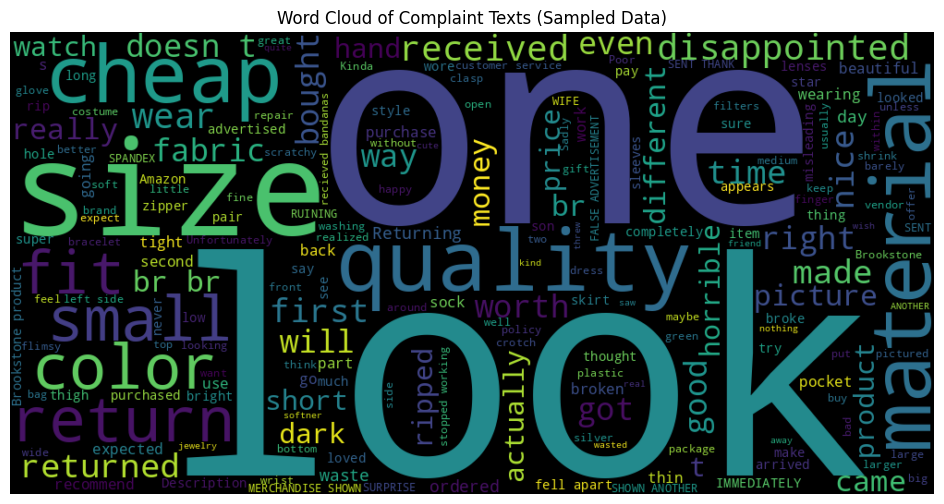

Cell 2.4: Visual Analytics for TransactionHistoryDF completed.


In [9]:
# Snippet 2.4: Visual Analytics on Pre-SFT Merged Data (TransactionHistoryDF)
if not TransactionHistoryDF.empty:
    print("\n--- Visualizing Sampled TransactionHistoryDF (Pre-SFT Data) ---")

    # 1. Inferred Complaint Driver Distribution in Sampled Data
    if 'inferred_complaint_driver' in TransactionHistoryDF.columns: # This column was added to df_complaints_source_filtered
                                                                  # Ensure it's carried to TransactionHistoryDF or re-infer
        # Re-infer if not present from the merge source (df_complaints_for_sft_source)
        if 'inferred_complaint_driver' not in TransactionHistoryDF.columns and 'complaint_body_text' in TransactionHistoryDF.columns:
             TransactionHistoryDF['inferred_complaint_driver'] = TransactionHistoryDF['complaint_body_text'].apply(infer_complaint_driver)

        if 'inferred_complaint_driver' in TransactionHistoryDF.columns:
            fig_driver = px.histogram(TransactionHistoryDF, x="inferred_complaint_driver",
                                      title="SAMPLED Data: Inferred Complaint Driver Distribution",
                                      template="plotly_dark", color="inferred_complaint_driver").update_xaxes(categoryorder="total descending")
            fig_driver.show()
            print("Target Proportions for Fashion SFT Generation (for comparison):")
            for reason, prop_val in target_proportions_for_sampling.items():
                 print(f"  - {reason}: {prop_val*100:.1f}% (Target)")
        else:
            print("Could not plot inferred_complaint_driver distribution.")


    # 2. Complaint Rating Distribution (should be all <=2)
    if 'complaint_rating_given' in TransactionHistoryDF.columns:
        fig_rating = px.histogram(TransactionHistoryDF, x="complaint_rating_given",
                                  title="SAMPLED Data: Distribution of Complaint Ratings",
                                  nbins=int(TransactionHistoryDF["complaint_rating_given"].max()*2) if TransactionHistoryDF["complaint_rating_given"].max() > 0 else 5,
                                  template="plotly_dark", color="complaint_rating_given")
        fig_rating.show()

    # 3. Product Main Category Distribution in Sampled Complaints
    if 'product_main_category' in TransactionHistoryDF.columns:
        category_counts = TransactionHistoryDF['product_main_category'].value_counts().nlargest(15)
        fig_cat = px.bar(category_counts, x=category_counts.index, y=category_counts.values,
                         title="SAMPLED Data: Top 15 Product Main Categories in Complaints", labels={'index':'Category', 'y':'Count'},
                         template="plotly_dark", color=category_counts.index)
        fig_cat.show()

    # 4. Temporal Complaint Volume (Weekly)
    if 'complaint_timestamp_iso' in TransactionHistoryDF.columns:
        # Convert ISO string to datetime for Grouper
        temp_ts_df = TransactionHistoryDF.copy()
        temp_ts_df['complaint_datetime_for_plot'] = pd.to_datetime(temp_ts_df['complaint_timestamp_iso'], errors='coerce')
        temp_ts_df.dropna(subset=['complaint_datetime_for_plot'], inplace=True)
        if not temp_ts_df.empty:
            complaints_by_week = temp_ts_df.groupby(pd.Grouper(key='complaint_datetime_for_plot', freq='W'))['user_id'].count().reset_index(name='count')
            if not complaints_by_week.empty:
                fig_time = px.line(complaints_by_week, x='complaint_datetime_for_plot', y='count', title="SAMPLED Data: Complaint Volume Over Time (Weekly)", template="plotly_dark")
                fig_time.show()
            else: print("Not enough data points for weekly complaint volume plot.")
        else: print("No valid timestamps for complaint volume plot.")


    # 5. Word Cloud for Complaint Text
    if 'complaint_body_text' in TransactionHistoryDF.columns:
        all_complaint_text = " ".join(TransactionHistoryDF['complaint_body_text'].dropna().astype(str))
        if all_complaint_text.strip():
            try:
                wordcloud = WordCloud(width=1000, height=500, background_color='black', colormap="viridis").generate(all_complaint_text)
                plt.figure(figsize=(12, 6))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.axis("off")
                plt.title("Word Cloud of Complaint Texts (Sampled Data)")
                plt.show()
            except Exception as e_wc:
                print(f"Could not generate word cloud: {e_wc}")
        else:
            print("No text data available for word cloud in complaints (sampled data).")
else:
    print("TransactionHistoryDF is empty, skipping pre-SFT visualizations.")

print("Cell 2.4: Visual Analytics for TransactionHistoryDF completed.")

In [10]:
# Snippet 3.1: SFT Data Generation Loop (RAFT-Style)

sft_generated_data_list = []
total_sft_start_time = time.time()
successful_generations_count = 0
failed_generations_count = 0

if not gemini_model_instance:
    print("CRITICAL ERROR: Gemini model instance is not initialized. Cannot proceed with SFT data generation.")
elif not policy_collection: # Check if policy_collection was successfully initialized
    print("CRITICAL ERROR: PolicyDB collection (policy_collection) is not available. Cannot proceed.")
elif TransactionHistoryDF.empty:
    print("CRITICAL ERROR: TransactionHistoryDF is empty. No data to generate SFT samples from.")
else:
    num_samples_to_process_sft = len(TransactionHistoryDF)
    print(f"\nAttempting to generate {num_samples_to_process_sft} SFT entries using RAFT-style prompts...")

    for index, row in tqdm(TransactionHistoryDF.iterrows(), total=num_samples_to_process_sft, desc="Generating RAFT SFT Entries"):
        try:
            # Extract data from the current row using the standardized names from Cell 2.3
            complaint_title_text = str(row.get('complaint_title_text', "N/A"))
            complaint_body_text = str(row.get('complaint_body_text', ""))
            complaint_rating_given = float(row.get('complaint_rating_given', 0.0))
            complaint_verified_purchase = bool(row.get('complaint_verified_purchase', False))
            complaint_helpful_votes = int(row.get('complaint_helpful_votes', 0))
            complaint_timestamp_dt = row.get('timestamp_review_dt')
            complaint_timestamp_iso = complaint_timestamp_dt.isoformat() if pd.notna(complaint_timestamp_dt) else "N/A"

            # This is the inferred driver from Cell 2.3 for the current complaint
            current_inferred_driver = str(row.get('inferred_complaint_driver', 'Other Negative Experience'))


            product_title = str(row.get('product_title', "N/A"))
            product_asin = str(row.get('product_asin', "N/A"))
            product_price_float = float(row.get('product_price', 0.0)) # Get as float first
            product_price_str = f"{product_price_float:.2f}" # Then format as string
            product_main_category = str(row.get('product_main_category', "N/A"))
            product_sub_category = str(row.get('product_sub_category', "N/A")) # Already processed in 2.3
            product_store = str(row.get('product_store', "N/A"))
            product_features = str(row.get('product_features', "N/A"))
            product_avg_rating = str(row.get('product_avg_rating', "N/A"))
            product_rating_number = str(row.get('product_rating_number', "N/A"))
            image_urls_str = str(row.get('image_urls_str', "No product images available"))

            purchase_date_dt = complaint_timestamp_dt - timedelta(days=random.randint(5, 25)) if pd.notna(complaint_timestamp_dt) else datetime.now() - timedelta(days=random.randint(5,25))
            purchase_date_str = purchase_date_dt.strftime('%Y-%m-%d')

            user_id = str(row.get('user_id'))
            udp_hist_source_df = df_reviews_full_for_udp_context if not df_reviews_full_for_udp_context.empty else TransactionHistoryDF
            udp_summary, _ = get_udp_summary_and_features_from_db(user_id, complaint_timestamp_dt, udp_hist_source_df, udp_collection)

            golden_policies, distractor_policies = get_policy_snippets_from_db(complaint_body_text, policy_collection, num_golden=2, num_distractors=2)

            teacher_prompt_guidance = ""
            if current_inferred_driver == "Defective/Damaged" or current_inferred_driver == "Quality Issue":
                teacher_prompt_guidance = "Guideline: This complaint indicates a potential defective/quality issue. If valid and within policy, a full refund (with or without return based on item value/policy specifics) is often appropriate. Ensure reasoning cites specific defect if mentioned."
            elif current_inferred_driver == "Sizing Issue":
                teacher_prompt_guidance = "Guideline: This complaint is about sizing. An exchange for a correct size or a return for refund (if item is unworn with tags) is common. Check return window."
            elif current_inferred_driver == "Not as Described/Wrong Item":
                 teacher_prompt_guidance = "Guideline: Item may not match description or be the wrong item. Resolution often involves return for refund or replacement. Verify details against product information."
            elif current_inferred_driver == "Shipping Problem":
                 teacher_prompt_guidance = "Guideline: Complaint relates to shipping (late, packaging). Assess if Amazon is at fault. A partial refund for shipping or a gesture of goodwill might be considered if delivery was significantly delayed by Amazon."

            teacher_prompt_filled = TEACHER_PROMPT_TEMPLATE.format(
                complaint_title_text=complaint_title_text,
                complaint_rating_given=complaint_rating_given,
                complaint_body_text=complaint_body_text,
                complaint_verified_purchase=complaint_verified_purchase,
                complaint_helpful_votes=complaint_helpful_votes, # Added this placeholder to template
                complaint_timestamp_iso=complaint_timestamp_iso,
                complaint_inferred_driver_for_gemini=current_inferred_driver, # Pass inferred driver
                product_title=product_title,
                product_asin=product_asin,
                product_price=product_price_str, # Use formatted string
                product_main_category=product_main_category,
                product_sub_category=product_sub_category,
                product_store=product_store,
                product_features=product_features,
                product_avg_rating=product_avg_rating,
                product_rating_number=product_rating_number,
                user_dynamic_profile_summary=udp_summary,
                retrieved_relevant_policies_text=golden_policies,
                retrieved_distractor_policies_text=distractor_policies,
                purchase_date_str=purchase_date_str,
                image_urls_str=image_urls_str,
                max_json_output_tokens=MAX_JSON_OUTPUT_TOKENS_TARGET,
                additional_guidance_for_gemini=teacher_prompt_guidance
            )

            gemini_json_output_str = generate_sft_entry_with_gemini(teacher_prompt_filled)

            if gemini_json_output_str:
                student_prompt_text = STUDENT_PROMPT_BASE.format(
                    complaint_title_text=complaint_title_text,
                    complaint_body_text=complaint_body_text,
                    complaint_rating_given=complaint_rating_given,
                    complaint_verified_purchase=complaint_verified_purchase,
                    complaint_timestamp_iso=complaint_timestamp_iso,
                    complaint_inferred_driver_for_gemma=current_inferred_driver, # Pass to student prompt too
                    user_dynamic_profile_summary=udp_summary,
                    product_title=product_title,
                    product_asin=product_asin,
                    product_price=product_price_str, # Use formatted string
                    product_main_category=product_main_category,
                    product_sub_category=product_sub_category,
                    product_store=product_store,
                    image_urls_str=image_urls_str,
                    retrieved_relevant_policies_text=golden_policies,
                    retrieved_distractor_policies_text=distractor_policies,
                    purchase_date_str=purchase_date_str
                )
                try:
                    parsed_json_output = json.loads(gemini_json_output_str)
                    required_json_keys = ["is_actionable_complaint", "complaint_category", "decision_recommendation", "formal_answer_to_customer", "reasoning_for_decision", "detected_customer_sentiment", "detected_aggressiveness_level"]
                    if all(key in parsed_json_output for key in required_json_keys):
                        sft_generated_data_list.append({
                            "id": f"sft_raft_sample_{index}_{user_id}",
                            "input_prompt_for_gemma3": student_prompt_text,
                            "gemini_json_output": parsed_json_output
                        })
                        successful_generations_count += 1
                    else:
                        missing_keys = [k for k in required_json_keys if k not in parsed_json_output]
                        failed_generations_count += 1
                        tqdm.write(f"Gemini output missing required keys ({missing_keys}) for sample (Index: {index}). Raw: {gemini_json_output_str[:250]}")
                except json.JSONDecodeError as json_e:
                    failed_generations_count += 1
                    tqdm.write(f"Failed to parse JSON from Gemini for sample (Index: {index}): {json_e}. Raw: {gemini_json_output_str[:250]}")
            else:
                failed_generations_count += 1
                # tqdm.write(f"Gemini returned no text for sample (Index: {index}).") # Less verbose

            if (index + 1) % 20 == 0:
                tqdm.write(f"Progress: {index+1}/{num_samples_to_process_sft}. Success: {successful_generations_count}, Fail: {failed_generations_count}. Saving checkpoint...")
                checkpoint_path = os.path.join(OUTPUT_SFT_FOLDER, SFT_DATASET_FILENAME + "_checkpoint.jsonl")
                with open(checkpoint_path, 'w') as f_chk:
                    for entry_chk in sft_generated_data_list: f_chk.write(json.dumps(entry_chk) + '\n')

            time.sleep(random.uniform(2.0, 3.5))

        except Exception as e_outer_loop:
            failed_generations_count += 1
            tqdm.write(f"Critical error in SFT generation outer loop for sample (Index: {index}): {e_outer_loop}")
            traceback.print_exc()

    # Final save and summary (identical to previous response)
    # ...
    total_time_taken_sft_final = time.time() - total_sft_start_time
    print(f"\n--- SFT Data Generation Final Summary ---")
    print(f"Total time taken: {total_time_taken_sft_final:.2f} seconds")
    print(f"Successfully generated SFT entries: {successful_generations_count}")
    print(f"Failed SFT generations/parses: {failed_generations_count}")

    if sft_generated_data_list:
        print(f"\nSaving final {len(sft_generated_data_list)} generated SFT entries to {SFT_DATASET_FILE_PATH}...")
        with open(SFT_DATASET_FILE_PATH, 'w') as f:
            for entry in sft_generated_data_list:
                f.write(json.dumps(entry) + '\n')
        print("SFT data saved.")
        if sft_generated_data_list:
            print("\n--- First successfully generated SFT entry (RAFT-Style) ---")
            first_successful_entry = next((e for e in sft_generated_data_list if "gemini_json_output" in e and isinstance(e["gemini_json_output"],dict)), None)
            if first_successful_entry:
                print("Input Prompt for Gemma3 (Student - truncated):")
                print(str(first_successful_entry.get("input_prompt_for_gemma3", ""))[:700] + "...")
                print("\nTarget Gemini Output (JSON):")
                print(json.dumps(first_successful_entry["gemini_json_output"], indent=2))
            else:
                print("No successfully parsed JSON outputs to display from the generated entries.")
            print("-" * 50)
    else:
        print("\nNo SFT data was generated to save.")
    print(f"\nCheck the folder '{OUTPUT_SFT_FOLDER}' for the output file: {SFT_DATASET_FILE_PATH}")

print("Cell 3.1: SFT Data Generation Loop completed.")


Attempting to generate 100 SFT entries using RAFT-style prompts...


Generating RAFT SFT Entries:   0%|          | 0/100 [00:00<?, ?it/s]

Progress: 20/100. Success: 20, Fail: 0. Saving checkpoint...
Progress: 40/100. Success: 40, Fail: 0. Saving checkpoint...
Progress: 60/100. Success: 60, Fail: 0. Saving checkpoint...
Progress: 80/100. Success: 80, Fail: 0. Saving checkpoint...
Progress: 100/100. Success: 100, Fail: 0. Saving checkpoint...

--- SFT Data Generation Final Summary ---
Total time taken: 1465.98 seconds
Successfully generated SFT entries: 100
Failed SFT generations/parses: 0

Saving final 100 generated SFT entries to /content/drive/MyDrive/Google AI Studio/AmazonFashionSFT/sft_output_amazon_fashion_raft_final/amazon_fashion_sft_data_raft_final_v5.jsonl...
SFT data saved.

--- First successfully generated SFT entry (RAFT-Style) ---
Input Prompt for Gemma3 (Student - truncated):

Customer Complaint:
Title: FALSE ADVERTISEMENT! PICTURES ONE ITEM, SENT ANOTHER ITEM!
Review: FALSE ADVERTISEMENT!!! ONE MERCHANDISE SHOWN, ANOTHER SENT!!!  THANK YOU RUINING THE SURPRISE FOR MY WIFE!!!!! THEY WILL BE RETURNED IMMEDIA

In [11]:
# Snippet 3.2: Visual Analytics on Generated SFT Dataset

if sft_generated_data_list:
    df_sft_generated = pd.DataFrame(sft_generated_data_list)
    # Filter out rows where gemini_json_output might be a raw string due to parse error
    df_sft_generated_parsed = df_sft_generated[df_sft_generated['gemini_json_output'].apply(lambda x: isinstance(x, dict))].copy()

    if not df_sft_generated_parsed.empty:
        print(f"\n--- Visualizing Generated SFT Dataset ({len(df_sft_generated_parsed)} successfully parsed entries) ---")

        def extract_from_parsed_json(parsed_dict, key, sub_key=None, default_val="N/A"):
            if sub_key:
                return parsed_dict.get(key, {}).get(sub_key, default_val)
            return parsed_dict.get(key, default_val)

        df_sft_generated_parsed['sft_complaint_category'] = df_sft_generated_parsed['gemini_json_output'].apply(lambda x: extract_from_parsed_json(x, 'complaint_category'))
        df_sft_generated_parsed['sft_decision_recommendation'] = df_sft_generated_parsed['gemini_json_output'].apply(lambda x: extract_from_parsed_json(x, 'decision_recommendation'))
        df_sft_generated_parsed['sft_tone'] = df_sft_generated_parsed['gemini_json_output'].apply(lambda x: extract_from_parsed_json(x, 'formal_answer_to_customer')).apply(lambda x: re.search(r"\[TONE:\s*(.*?)\s*\]", str(x)).group(1).strip() if isinstance(x, str) and re.search(r"\[TONE:\s*(.*?)\s*\]", str(x)) else "N/A")
        df_sft_generated_parsed['sft_sentiment'] = df_sft_generated_parsed['gemini_json_output'].apply(lambda x: extract_from_parsed_json(x, 'detected_customer_sentiment'))
        df_sft_generated_parsed['sft_aggression'] = df_sft_generated_parsed['gemini_json_output'].apply(lambda x: extract_from_parsed_json(x, 'detected_aggressiveness_level'))

        # Token Lengths (using a simple whitespace split as a proxy if Gemini tokenizer is slow/complex here)
        df_sft_generated_parsed['student_prompt_tokens_approx'] = df_sft_generated_parsed['input_prompt_for_gemma3'].astype(str).apply(lambda x: len(x.split()))
        df_sft_generated_parsed['target_json_tokens_approx'] = df_sft_generated_parsed['gemini_json_output'].astype(str).apply(lambda x: len(str(x).split())) # Stringify dict then split

        # 1. Distribution of Complaint Categories in SFT data
        fig_sft_cat = px.histogram(df_sft_generated_parsed, x="sft_complaint_category", title="SFT: Generated Complaint Category Distribution", template="plotly_dark", color="sft_complaint_category").update_xaxes(categoryorder="total descending")
        fig_sft_cat.show()
        print("SFT Generated Complaint Category Distribution (%):")
        print(df_sft_generated_parsed['sft_complaint_category'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')


        # 2. Distribution of Decision Recommendations in SFT data
        fig_sft_dec = px.histogram(df_sft_generated_parsed, x="sft_decision_recommendation", title="SFT: Generated Decision Recommendation Distribution", template="plotly_dark", color="sft_decision_recommendation").update_xaxes(categoryorder="total descending")
        fig_sft_dec.show()
        print("SFT Generated Decision Recommendation Distribution (%):")
        print(df_sft_generated_parsed['sft_decision_recommendation'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

        # 3. Sentiment & Aggressiveness Sunburst Chart
        if 'sft_sentiment' in df_sft_generated_parsed.columns and 'sft_aggression' in df_sft_generated_parsed.columns:
            path_cols_sunburst = [col for col in ['sft_sentiment', 'sft_aggression'] if df_sft_generated_parsed[col].nunique() > 1]
            if len(path_cols_sunburst) > 0:
                df_sft_generated_parsed['count_for_sunburst'] = 1
                fig_sunburst = px.sunburst(df_sft_generated_parsed.fillna("N/A"), path=path_cols_sunburst, values='count_for_sunburst', title="SFT: Sentiment & Aggression Levels", template="plotly_dark", color=path_cols_sunburst[0])
                fig_sunburst.show()

        # 4. Token Lengths of Student Prompts and Target JSONs
        fig_lengths_box = px.box(df_sft_generated_parsed[['student_prompt_tokens_approx', 'target_json_tokens_approx']].melt(),
                             y="value", x="variable", points="all",
                             title="SFT: Approx. Token Length Distributions (Student Prompt vs. Target JSON)",
                             template="plotly_dark", color="variable")
        fig_lengths_box.show()
        print(df_sft_generated_parsed[['student_prompt_tokens_approx', 'target_json_tokens_approx']].describe())

    else:
        print("No successfully parsed SFT data with 'gemini_json_output' (as dict) to visualize.")
else:
    print("SFT data generation was skipped or failed, no SFT visualizations to show.")

print("Cell 3.2: Visual Analytics for Generated SFT Dataset completed.")


--- Visualizing Generated SFT Dataset (100 successfully parsed entries) ---


SFT Generated Complaint Category Distribution (%):
sft_complaint_category
Quality Issue          48.0%
Not as Described       21.0%
Sizing Issue           19.0%
Damaged Item            6.0%
Wrong Item Received     4.0%
Shipping Problem        2.0%
Name: proportion, dtype: object


SFT Generated Decision Recommendation Distribution (%):
sft_decision_recommendation
Full_Refund_With_Return         45.0%
Full_Refund_No_Return           32.0%
Further_Information_Required    10.0%
Exchange_Offered                 9.0%
Other_Resolution                 2.0%
Provide_Policy_Information       1.0%
Apology_Only                     1.0%
Name: proportion, dtype: object


       student_prompt_tokens_approx  target_json_tokens_approx
count                    100.000000                 100.000000
mean                     269.380000                 223.090000
std                       37.615755                  27.661407
min                      217.000000                 158.000000
25%                      246.750000                 205.500000
50%                      265.000000                 225.500000
75%                      281.500000                 242.250000
max                      559.000000                 282.000000
Cell 3.2: Visual Analytics for Generated SFT Dataset completed.
